# Data Imputation for Part A

In [207]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL
from sktime.forecasting.arima import AutoARIMA
# import statsmodels.api as sm
# import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.arima.model import ARIMA
import warnings

In [208]:
parking_missing_values = pd.read_csv("parkingLot_missing_values.csv")
parking_missing_values

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
1,MHYN4677,2024-09-12 05:00:00,1
2,MHEL6595,2024-09-12 05:00:00,1
3,MHNQ2590,2024-09-12 05:00:00,1
4,MHHA0518,2024-09-12 05:00:00,1
...,...,...,...
93183,MHFO0975,2024-11-13 23:40:00,2
93184,MHCG9551,2024-11-13 23:40:00,2
93185,MHCR0569,2024-11-13 23:40:00,2
93186,MHTR9210,2024-11-13 23:40:00,2


In [209]:
parking_missing_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93188 entries, 0 to 93187
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   vehicle_no  92853 non-null  object
 1   timestamp   93188 non-null  object
 2   camera_id   93188 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.1+ MB


In [210]:
# get the null values
parking_missing_values.isnull().sum()

vehicle_no    335
timestamp       0
camera_id       0
dtype: int64

In [211]:
car_entering_data = parking_missing_values[(parking_missing_values['camera_id']==1)]
warnings.filterwarnings('ignore')
car_entering_data['timestamp'] = pd.to_datetime(car_entering_data['timestamp'])

In [212]:
warnings.filterwarnings('ignore')
car_entering_data['Count'] = 1

In [213]:
cars_per_day = car_entering_data.groupby(pd.Grouper(key='timestamp', freq='D'))['Count'].sum()

In [214]:
# make cars_per_day a dataframe
cars_per_day = cars_per_day.to_frame()

In [215]:
cars_per_day

,Count
timestamp,
2024-09-12,886
2024-09-13,809
2024-09-14,0
2024-09-15,1073
2024-09-16,843
...,...
2024-11-09,906
2024-11-10,944
2024-11-11,828


In [216]:
cars_per_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63 entries, 2024-09-12 to 2024-11-13
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   63 non-null     int64
dtypes: int64(1)
memory usage: 1008.0 bytes


<Axes: title={'center': 'Cars entering per day'}, xlabel='timestamp'>

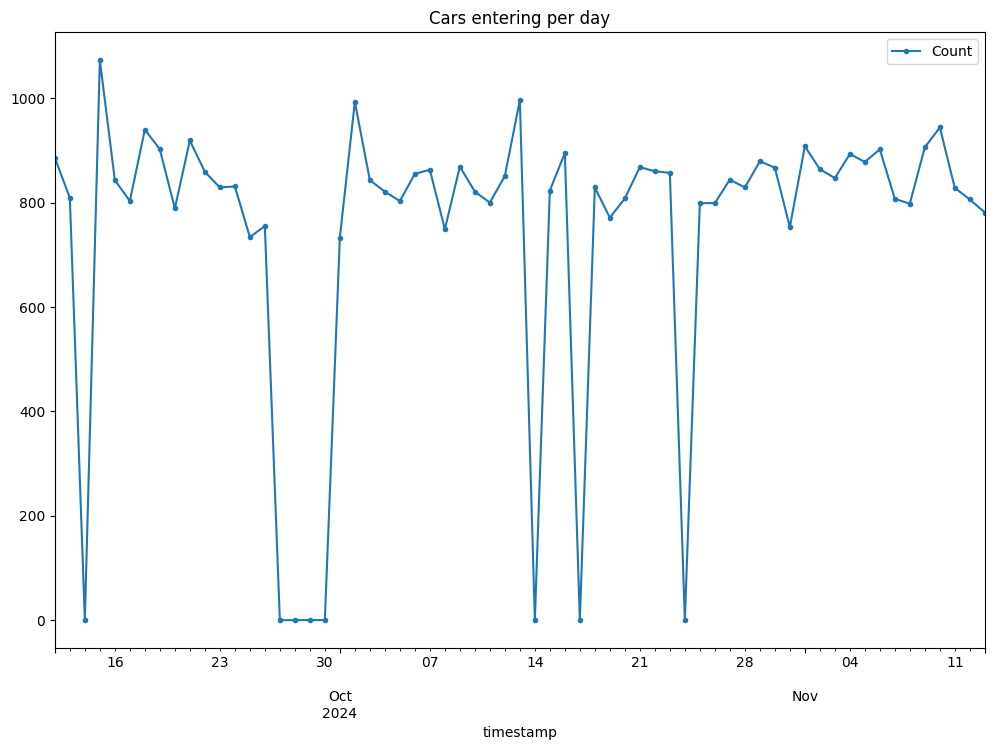

In [217]:
cars_per_day.plot(style='.-', figsize=(12,8), title="Cars entering per day")

As we can observe, some days have no records of cars entering i.e. the count goes to zero. Hence, we have missing values on these days, and we would need to implement missing value imputation strategies to conunter this.

#### Changing the zero values into nan for imputation

In [218]:
cars_per_day.replace(0, np.nan, inplace=True)

## Linear Interpolation

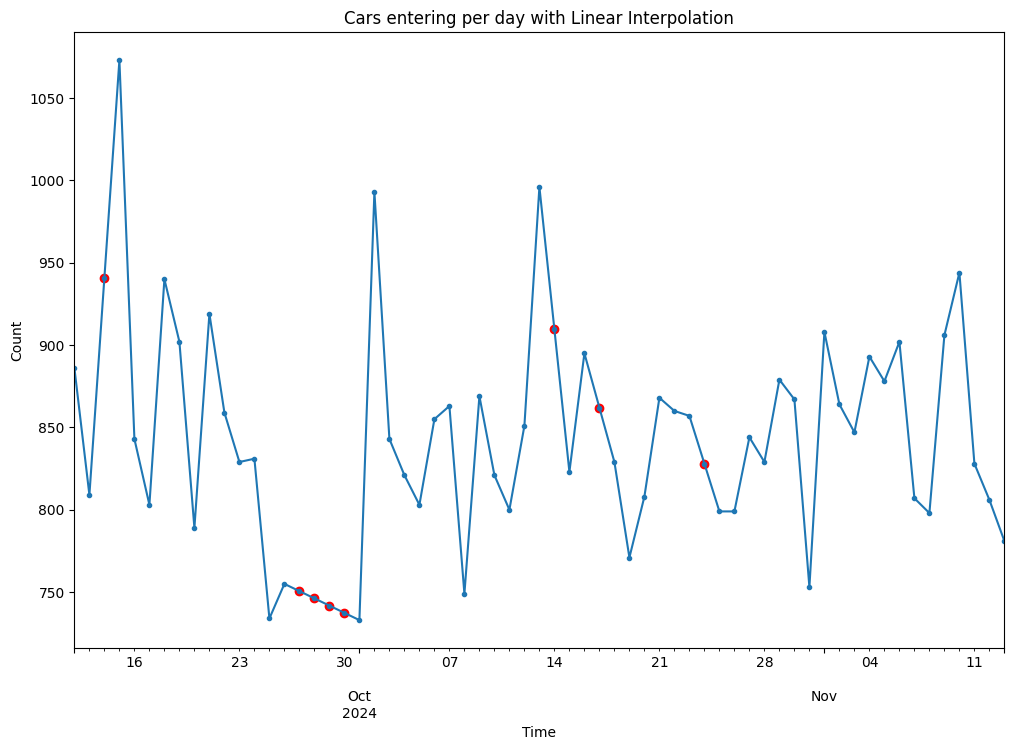

In [219]:
# Apply the linear interpolation method

linear_imputed = cars_per_day.interpolate(method ='linear', limit_direction ='forward')

# Plot the main line with markers
linear_imputed['Count'].plot(style='.-', figsize=(12,8), title='Cars entering per day with Linear Interpolation')

# Add points where data was imputed with red color
imputed_indices = cars_per_day[cars_per_day['Count'].isnull()].index
plt.scatter(imputed_indices, linear_imputed.loc[imputed_indices, 'Count'], color='red')

# Set labels
plt.xlabel('Time')
plt.ylabel('Count')

plt.show()

In [220]:
linear_imputed

,Count
timestamp,
2024-09-12,886.0
2024-09-13,809.0
2024-09-14,941.0
2024-09-15,1073.0
2024-09-16,843.0
...,...
2024-11-09,906.0
2024-11-10,944.0
2024-11-11,828.0


#### Creating the test/train split

In [221]:
linear_test_len = int(len(linear_imputed)*0.12)
linear_train, linear_test = linear_imputed[:-linear_test_len], linear_imputed[-linear_test_len:]


In [222]:
linear_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 2024-09-12 to 2024-11-06
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Count   56 non-null     float64
dtypes: float64(1)
memory usage: 896.0 bytes


In [223]:
linear_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7 entries, 2024-11-07 to 2024-11-13
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Count   7 non-null      float64
dtypes: float64(1)
memory usage: 112.0 bytes


In [224]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Calculate Mean Absolute Scaled Error (MASE)
    
    Parameters:
    y_true (array-like): Actual values
    y_pred (array-like): Predicted values
    
    Returns:
    float: MASE value
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    n = len(y_true)
    mae = np.mean(np.abs(y_true - y_pred))
    naive_mae = np.mean(np.abs(y_true[1:] - y_true[:-1]))
	
	# THe naive predictor used here is the previous value.

    return mae / naive_mae

In [225]:
def mean_absolute_percentage_error(y_true, y_pred):
	"""
	Calculate Mean Absolute Percentage Error (MAPE)
	
	Parameters:
	y_true (array-like): Actual values
	y_pred (array-like): Predicted values
	
	Returns:
	float: MAPE value
	"""
	y_true = np.array(y_true)
	y_pred = np.array(y_pred)
	
	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### Forecasting using the AutoARIMA Model after linear interpolation

In [226]:
warnings.filterwarnings('ignore')
linear_forecaster = AutoARIMA( start_p=0, max_p=3,suppress_warnings=True, seasonal=False)
linear_forecaster.fit(linear_train)
linear_forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -313.816
Date:                Mon, 28 Oct 2024   AIC                            633.632
Time:                        23:18:10   BIC                            639.708
Sample:                    09-12-2024   HQIC                           635.987
                         - 11-06-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    844.5675     13.850     60.979      0.000     817.422     871.713
ma.L1          0.3388      0.121      2.792      0.005       0.101       0.577
sigma2      4304.4219    855.854      5.029      0.000    2626.979    5981.865
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 8.08
Prob(Q):                              0.77   Prob(JB):                         0.02
Heteroskedasticity (H):               0.29   Skew:                             0.86
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [227]:
linear_forecast = linear_forecaster.predict(fh=range(len(linear_test)))
linear_forecast_range = linear_forecaster.predict_interval(fh=range(len(linear_test)))
linear_mase = mean_absolute_scaled_error(linear_test, linear_forecast)
linear_mape = mean_absolute_percentage_error(linear_test, linear_forecast)
print("MASE with linear interpolation: ", linear_mase)
print("MAPE with linear interpolation: ", linear_mape)

MASE with linear interpolation:  1.0435314140612533
MAPE with linear interpolation:  6.5227907486244


### Seasonal Trend Decomposition using Loess (STL) Imputation

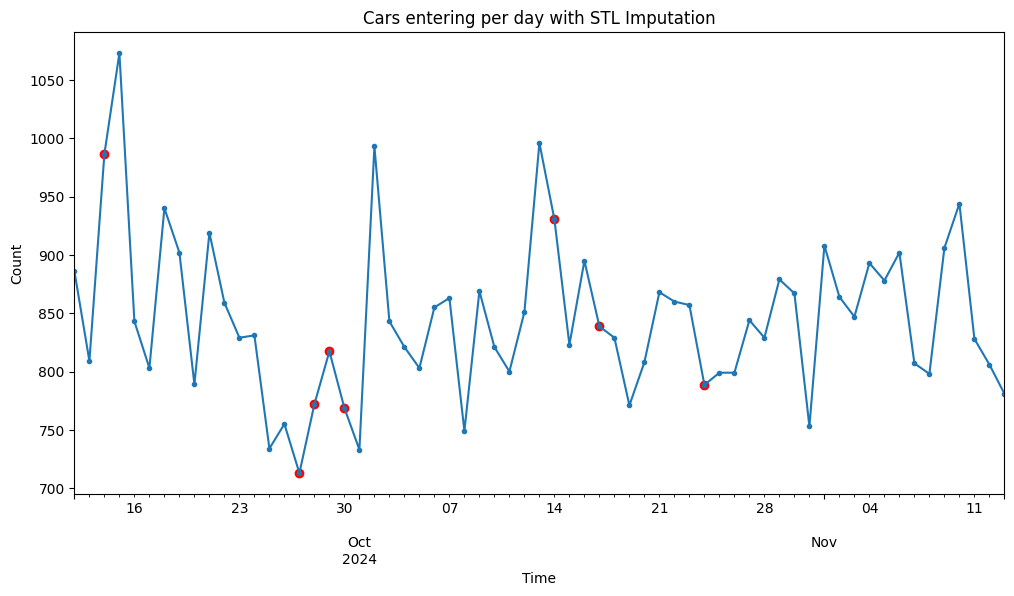

In [228]:
# Make a copy of the original dataframe
stl_imputed = cars_per_day.copy()

# Fill missing values in the time series
imputed_indices = cars_per_day[cars_per_day['Count'].isnull()].index
# Apply STL decompostion
stl = STL(stl_imputed['Count'].interpolate(), seasonal=7)
res = stl.fit()

# Extract the seasonal and trend components
seasonal_component = res.seasonal

# Create the deseasonalised series
cars_per_day_deseasonalised = stl_imputed['Count'] - seasonal_component

# Interpolate missing values in the deseasonalised series
cars_per_day_deseasonalised_imputed = cars_per_day_deseasonalised.interpolate(method="linear")

# Add the seasonal component back to create the final imputed series
cars_per_day_imputed = cars_per_day_deseasonalised_imputed + seasonal_component

# Update the original dataframe with the imputed values
stl_imputed.loc[imputed_indices, 'Count'] = cars_per_day_imputed[imputed_indices]

# Plot the series using pandas
plt.figure(figsize=[12, 6])
stl_imputed['Count'].plot(style='.-',  label='Cars entering per day with STL Imputation')
plt.scatter(imputed_indices, stl_imputed.loc[imputed_indices, 'Count'], color='red')

plt.title("Cars entering per day with STL Imputation")
plt.ylabel("Count")
plt.xlabel("Time")
plt.show()


In [229]:
stl_imputed

,Count
timestamp,
2024-09-12,886.00000
2024-09-13,809.00000
2024-09-14,986.58521
2024-09-15,1073.00000
2024-09-16,843.00000
...,...
2024-11-09,906.00000
2024-11-10,944.00000
2024-11-11,828.00000


#### Creating the train/test split

In [230]:
stl_test_len = int(len(stl_imputed)*0.12)
stl_train, stl_test = stl_imputed[:-stl_test_len], stl_imputed[-stl_test_len:]

In [231]:
stl_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 2024-09-12 to 2024-11-06
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Count   56 non-null     float64
dtypes: float64(1)
memory usage: 896.0 bytes


In [232]:
stl_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7 entries, 2024-11-07 to 2024-11-13
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Count   7 non-null      float64
dtypes: float64(1)
memory usage: 112.0 bytes


#### Forecasting using AutoARIMA after STL imputation

In [233]:
warnings.filterwarnings('ignore')
stl_forecaster = AutoARIMA( start_p=0, max_p=3,suppress_warnings=True, seasonal=False)
stl_forecaster.fit(stl_train)
stl_forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -314.731
Date:                Mon, 28 Oct 2024   AIC                            635.463
Time:                        23:18:13   BIC                            641.539
Sample:                    09-12-2024   HQIC                           637.818
                         - 11-06-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    846.2695     13.539     62.506      0.000     819.734     872.805
ma.L1          0.3110      0.111      2.809      0.005       0.094       0.528
sigma2      4450.2423    872.788      5.099      0.000    2739.608    6160.876
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 7.11
Prob(Q):                              0.78   Prob(JB):                         0.03
Heteroskedasticity (H):               0.30   Skew:                             0.82
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [234]:
stl_forecast = stl_forecaster.predict(fh=range(len(stl_test)))
stl_forecast_range = stl_forecaster.predict_interval(fh=range(len(stl_test)))
stl_mase = mean_absolute_scaled_error(stl_test, stl_forecast)
stl_mape = mean_absolute_percentage_error(stl_test, stl_forecast)
print("MASE with STL imputation: ", stl_mase)
print("MAPE with STL imputation: ", stl_mape)

MASE with STL imputation:  1.0509683348193843
MAPE with STL imputation:  6.579557510439731


Observing the MASE and MAPE values after linear interpolation and after STL imputation, we can see that STL imputation performs better and gives a lower error score.

In [235]:
del stl_forecaster
del linear_forecaster
del stl_imputed
del linear_imputed
del cars_per_day
del car_entering_data
del parking_missing_values
del cars_per_day_deseasonalised
del cars_per_day_deseasonalised_imputed
del cars_per_day_imputed
del imputed_indices

# Data Imputation for Part B

In [236]:
parking_missing_values = pd.read_csv("parkingLot_missing_values.csv")
parking_missing_values

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
1,MHYN4677,2024-09-12 05:00:00,1
2,MHEL6595,2024-09-12 05:00:00,1
3,MHNQ2590,2024-09-12 05:00:00,1
4,MHHA0518,2024-09-12 05:00:00,1
...,...,...,...
93183,MHFO0975,2024-11-13 23:40:00,2
93184,MHCG9551,2024-11-13 23:40:00,2
93185,MHCR0569,2024-11-13 23:40:00,2
93186,MHTR9210,2024-11-13 23:40:00,2


In [237]:
parking_missing_values.isnull().sum()

vehicle_no    335
timestamp       0
camera_id       0
dtype: int64

In [238]:
parking_missing_values['timestamp'] = pd.to_datetime(parking_missing_values['timestamp'])	

In [239]:
parking_missing_values['count'] = 1
parking_missing_values['day'] = parking_missing_values['timestamp'].dt.date

In [240]:
parking_missing_values['day']

0        2024-09-12
1        2024-09-12
2        2024-09-12
3        2024-09-12
4        2024-09-12
            ...    
93183    2024-11-13
93184    2024-11-13
93185    2024-11-13
93186    2024-11-13
93187    2024-11-13
Name: day, Length: 93188, dtype: object

In [241]:
full_date_range = pd.date_range(start=parking_missing_values['day'].min(), end=parking_missing_values['day'].max())

In [242]:
missing_dates = full_date_range.difference(parking_missing_values['day'])

In [243]:
print(missing_dates)

DatetimeIndex(['2024-09-14', '2024-09-27', '2024-09-28', '2024-09-29',
               '2024-09-30', '2024-10-14', '2024-10-17', '2024-10-24'],
              dtype='datetime64[ns]', freq=None)


In [244]:
parking_missing_values

,vehicle_no,timestamp,camera_id,count,day
0,MHUN7063,2024-09-12 05:00:00,1,1,2024-09-12
1,MHYN4677,2024-09-12 05:00:00,1,1,2024-09-12
2,MHEL6595,2024-09-12 05:00:00,1,1,2024-09-12
3,MHNQ2590,2024-09-12 05:00:00,1,1,2024-09-12
4,MHHA0518,2024-09-12 05:00:00,1,1,2024-09-12
...,...,...,...,...,...
93183,MHFO0975,2024-11-13 23:40:00,2,1,2024-11-13
93184,MHCG9551,2024-11-13 23:40:00,2,1,2024-11-13
93185,MHCR0569,2024-11-13 23:40:00,2,1,2024-11-13
93186,MHTR9210,2024-11-13 23:40:00,2,1,2024-11-13


Calculate the cars entering the mall on a given day. We will assume that no car spends more than one day at the mall.

In [245]:
num_cars_entering = parking_missing_values[parking_missing_values['camera_id'] == 1].groupby(['day','camera_id'])['count'].sum().unstack()
num_cars_entering = num_cars_entering[1]

In [246]:
parking_missing_values
# parking_missing_values.drop(columns=['count'], inplace=True)

,vehicle_no,timestamp,camera_id,count,day
0,MHUN7063,2024-09-12 05:00:00,1,1,2024-09-12
1,MHYN4677,2024-09-12 05:00:00,1,1,2024-09-12
2,MHEL6595,2024-09-12 05:00:00,1,1,2024-09-12
3,MHNQ2590,2024-09-12 05:00:00,1,1,2024-09-12
4,MHHA0518,2024-09-12 05:00:00,1,1,2024-09-12
...,...,...,...,...,...
93183,MHFO0975,2024-11-13 23:40:00,2,1,2024-11-13
93184,MHCG9551,2024-11-13 23:40:00,2,1,2024-11-13
93185,MHCR0569,2024-11-13 23:40:00,2,1,2024-11-13
93186,MHTR9210,2024-11-13 23:40:00,2,1,2024-11-13


In [247]:
# Separate DataFrames for camera_id 1 and camera_id 2
parking_missing_values_cam1 = parking_missing_values[parking_missing_values['camera_id'] == 1].copy()
parking_missing_values_cam2 = parking_missing_values[parking_missing_values['camera_id'] == 2].copy()

# Convert the timestamps to total minutes from midnight
# Round of seconds to the nearest minute
parking_missing_values_cam1['minutes'] = parking_missing_values_cam1['timestamp'].dt.hour * 60 + parking_missing_values_cam1['timestamp'].dt.minute 
parking_missing_values_cam2['minutes'] = parking_missing_values_cam2['timestamp'].dt.hour * 60 + parking_missing_values_cam2['timestamp'].dt.minute 

# Sum of times (in minutes) for each day for camera_id 1 and camera_id 2
sum_cam1 = parking_missing_values_cam1.groupby('day')['minutes'].sum().reset_index(name='sum_minutes_cam1')
sum_cam2 = parking_missing_values_cam2.groupby('day')['minutes'].sum().reset_index(name='sum_minutes_cam2')

# Merge the sums on 'day'
merged_parking_missing_values = pd.merge(sum_cam1, sum_cam2, on='day')

# Calculate the difference (in minutes) between the sums
merged_parking_missing_values['time_diff_minutes'] = merged_parking_missing_values['sum_minutes_cam2'] - merged_parking_missing_values['sum_minutes_cam1']

print(merged_parking_missing_values)

           day  sum_minutes_cam1  sum_minutes_cam2  time_diff_minutes
0   2024-09-12            651560            849600             198040
1   2024-09-13            545140            827400             282260
2   2024-09-15            643520           1162480             518960
3   2024-09-16            527460            917880             390420
4   2024-09-17            537580            835480             297900
5   2024-09-18            683140            936900             253760
6   2024-09-19            683480            827860             144380
7   2024-09-20            627340            726900              99560
8   2024-09-21            731440            865720             134280
9   2024-09-22            638480            814940             176460
10  2024-09-23            573940            829760             255820
11  2024-09-24            538380            867260             328880
12  2024-09-25            463240            789200             325960
13  2024-09-26      

In [248]:
merged_parking_missing_values.set_index('day',inplace=True)

In [249]:
average_time_spent = merged_parking_missing_values['time_diff_minutes'] / num_cars_entering
average_time_spent

day
2024-09-12    223.521445
2024-09-13    348.899876
2024-09-15    483.653308
2024-09-16    463.131673
2024-09-17    370.983811
2024-09-18    269.957447
2024-09-19    160.066519
2024-09-20    126.185044
2024-09-21    146.115343
2024-09-22    205.424913
2024-09-23    308.588661
2024-09-24    395.764140
2024-09-25    444.087193
2024-09-26    424.000000
2024-10-01    155.061392
2024-10-02    206.424975
2024-10-03    283.060498
2024-10-04    341.315469
2024-10-05    400.821918
2024-10-06    413.286550
2024-10-07    382.502897
2024-10-08    327.263017
2024-10-09    250.817031
2024-10-10    192.155907
2024-10-11    194.000000
2024-10-12    205.851939
2024-10-13    262.028112
2024-10-15    377.351154
2024-10-16    380.245810
2024-10-18    334.788902
2024-10-19    278.936446
2024-10-20    235.049505
2024-10-21    222.649770
2024-10-22    222.069767
2024-10-23    254.772462
2024-10-25    321.351690
2024-10-26    375.093867
2024-10-27    354.573460
2024-10-28    345.790109
2024-10-29    294.470

In [250]:
len(average_time_spent)

55

In [251]:
for index in  missing_dates:
    print(index.date())
    average_time_spent.loc[index.date()] = 0

2024-09-14
2024-09-27
2024-09-28
2024-09-29
2024-09-30
2024-10-14
2024-10-17
2024-10-24


<Axes: xlabel='day'>

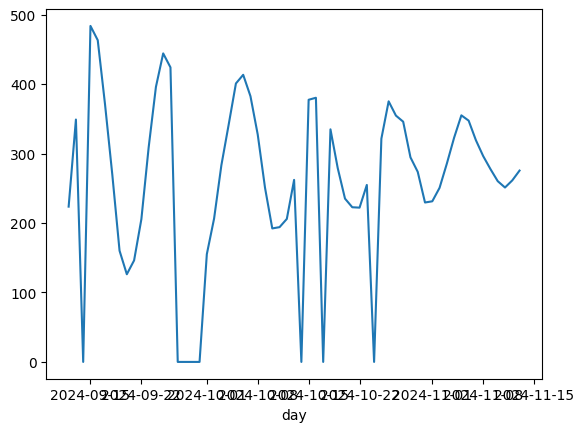

In [252]:
average_time_spent.plot()

In [253]:
print(len(average_time_spent))
average_time_spent[missing_dates]

63


2024-09-14    0.0
2024-09-27    0.0
2024-09-28    0.0
2024-09-29    0.0
2024-09-30    0.0
2024-10-14    0.0
2024-10-17    0.0
2024-10-24    0.0
dtype: float64

In [254]:
average_time_spent.replace(0, np.nan, inplace=True)

In [255]:
# SOr the data by index
average_time_spent.sort_index(inplace=True)

In [256]:
average_time_spent

day
2024-09-12    223.521445
2024-09-13    348.899876
2024-09-14           NaN
2024-09-15    483.653308
2024-09-16    463.131673
                 ...    
2024-11-09    277.571744
2024-11-10    260.190678
2024-11-11    251.038647
2024-11-12    261.315136
2024-11-13    275.441741
Length: 63, dtype: float64

Now that the data is constructed, we will have to perform imputattions.

## Quadratic Interpolation

In [257]:
average_time_spent.index = pd.to_datetime(average_time_spent.index)
quadratic_imputed = average_time_spent.interpolate(method='quadratic', inplace=False)

<Axes: xlabel='day'>

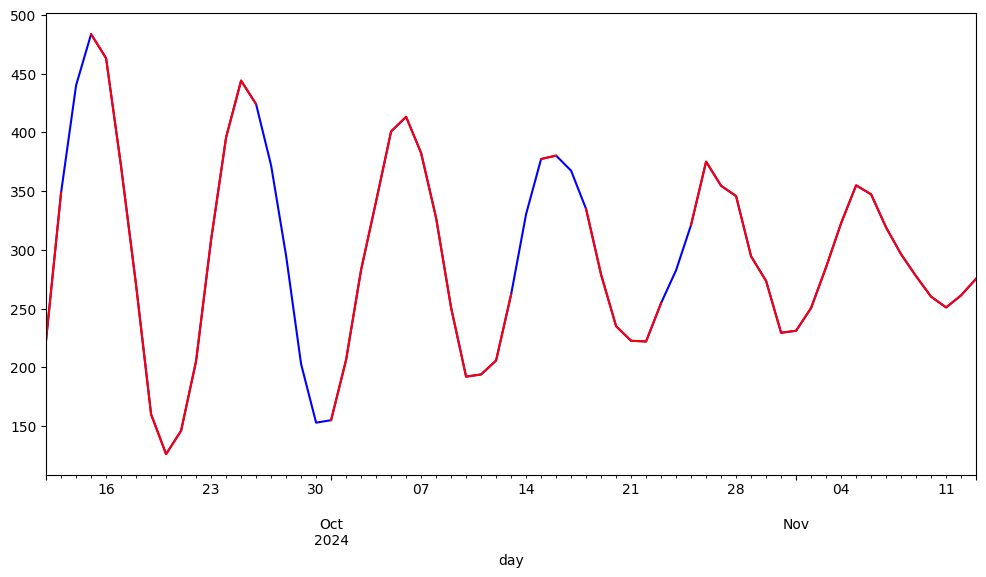

In [258]:
plt.figure(figsize=[12, 6])
quadratic_imputed.plot(color='b')
average_time_spent.plot(color='r')

In [259]:
_test, _train = quadratic_imputed[-linear_test_len:], quadratic_imputed[:-linear_test_len]


### Forecasting

In [260]:
warnings.filterwarnings('ignore')
quadratic_forecaster = AutoARIMA( start_p=0, max_p=3,suppress_warnings=True, seasonal=False)
quadratic_forecaster.fit(_train)
quadratic_forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -216.800
Date:                Mon, 28 Oct 2024   AIC                            445.600
Time:                        23:18:27   BIC                            457.752
Sample:                    09-12-2024   HQIC                           450.311
                         - 11-06-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    178.6732     18.771      9.518      0.000     141.882     215.465
ar.L1          0.9513      0.176      5.415      0.000       0.607       1.296
ar.L2          0.1218      0.290      0.421      0.674      -0.446       0.690
ar.L3         -0.6824      0.176     -3.876      0.000      -1.027      -0.337
ma.L1         -0.4793      0.178     -2.694      0.007      -0.828      -0.131
sigma2       113.6306     21.319      5.330      0.000      71.846     155.416
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.25
Prob(Q):                              1.00   Prob(JB):                         0.88
Heteroskedasticity (H):               0.96   Skew:                             0.11
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [261]:
qudratic_forecast = quadratic_forecaster.predict(fh=range(len(_test)))
quadratic_forecast_range = quadratic_forecaster.predict_interval(fh=range(len(_test)))
quadratic_mase = mean_absolute_scaled_error(_test, qudratic_forecast)
quadratic_mape = mean_absolute_percentage_error(_test, qudratic_forecast)
print("MASE with quadratic interpolation: ", quadratic_mase)
print("MAPE with quadratic interpolation: ", quadratic_mape)


MASE with quadratic interpolation:  1.6148524348431799
MAPE with quadratic interpolation:  8.753522216230564


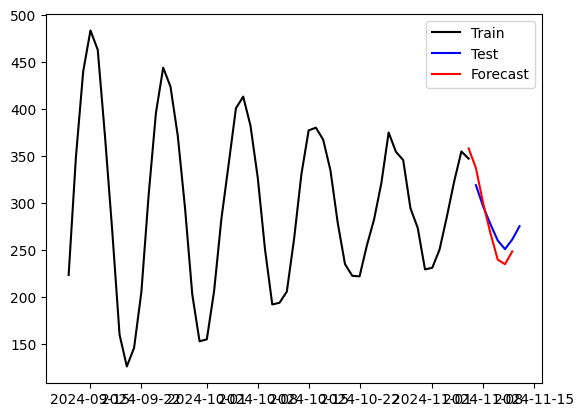

In [262]:
plt.plot(_train, label='Train', color='black')
plt.plot(_test, label='Test', color='blue')	
plt.plot(qudratic_forecast, label='Forecast', color='red')
plt.legend()
plt.show()

THE PERFORMANCE ISN'T MUCH FAVORABLE

## First Order Spline Interpolation

In [263]:
imputed = average_time_spent.interpolate(method='slinear', inplace=False)

<Axes: xlabel='day'>

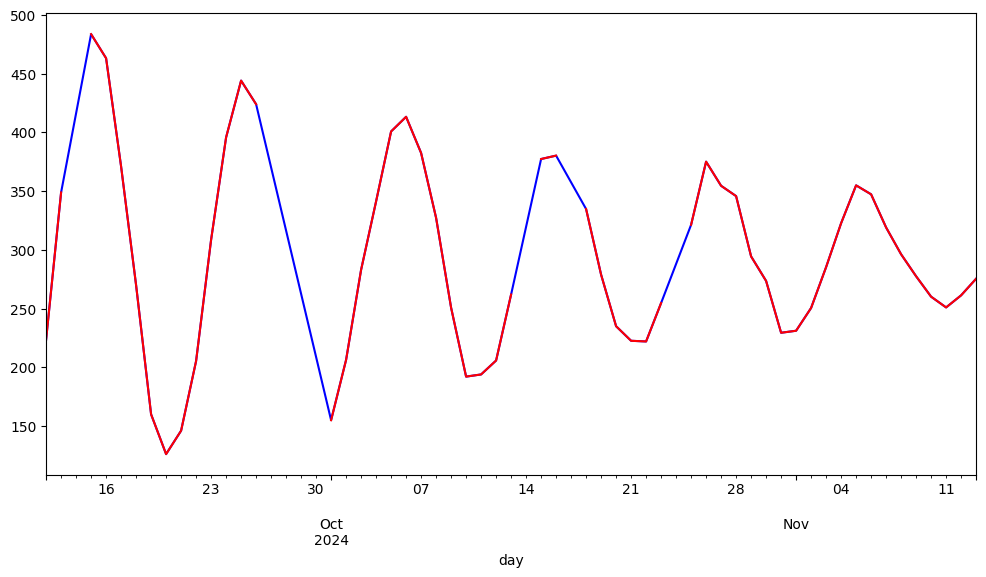

In [264]:
plt.figure(figsize=[12, 6])
imputed.plot(color='b')
average_time_spent.plot(color='r')

In [265]:
_test, _train = imputed[-linear_test_len:], imputed[:-linear_test_len]


### Forecasting

In [266]:
warnings.filterwarnings('ignore')
slinear_forecaster = AutoARIMA( start_p=0, max_p=3,suppress_warnings=True, seasonal=False)
slinear_forecaster.fit(_train)
slinear_forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -230.944
Date:                Mon, 28 Oct 2024   AIC                            473.888
Time:                        23:18:44   BIC                            486.040
Sample:                    09-12-2024   HQIC                           478.600
                         - 11-06-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    106.9447      4.027     26.555      0.000      99.051     114.838
ar.L1          1.6282      0.016    104.775      0.000       1.598       1.659
ar.L2         -0.9901      0.005   -199.233      0.000      -1.000      -0.980
ma.L1         -1.0230      0.111     -9.180      0.000      -1.241      -0.805
ma.L2          0.2419      0.117      2.069      0.039       0.013       0.471
sigma2       187.5562     40.808      4.596      0.000     107.574     267.538
===================================================================================
Ljung-Box (L1) (Q):                   1.43   Jarque-Bera (JB):                 2.23
Prob(Q):                              0.23   Prob(JB):                         0.33
Heteroskedasticity (H):               0.41   Skew:                             0.47
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [269]:
slinear_forecast = slinear_forecaster.predict(fh=range(len(_test)))
slinear_forecast_range = slinear_forecaster.predict_interval(fh=range(len(_test)))
slinear_mase = mean_absolute_scaled_error(_test, slinear_forecast)
slinear_mape = mean_absolute_percentage_error(_test, slinear_forecast)
print("MASE with slinear interpolation: ", slinear_mase)
print("MAPE with slinear interpolation: ", slinear_mape)


MASE with slinear interpolation:  1.562549053313516
MAPE with slinear interpolation:  8.397068846007212


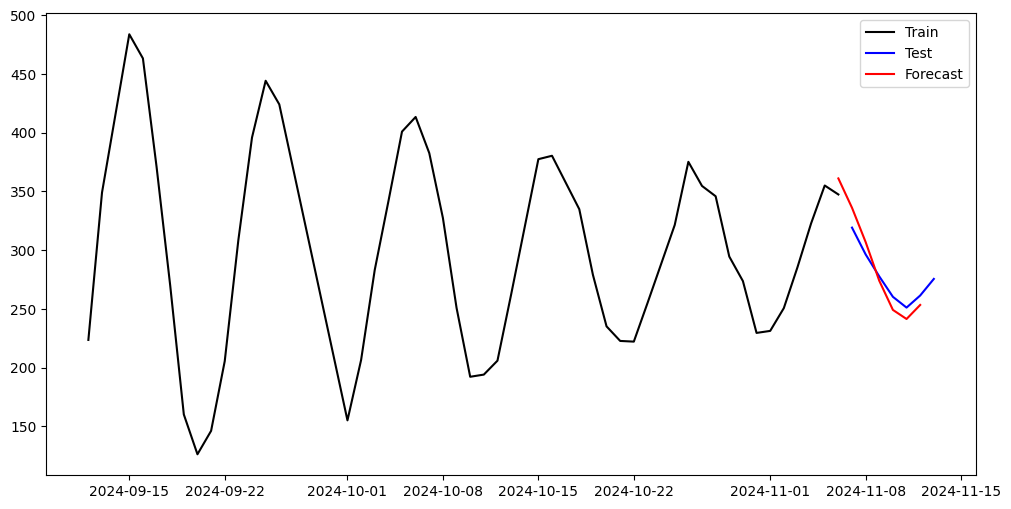

In [268]:
plt.figure(figsize=[12, 6])
plt.plot(_train, label='Train', color='black')
plt.plot(_test, label='Test', color='blue')
plt.plot(slinear_forecast, label='Forecast', color='red')
plt.legend()
plt.show()


Again, this forecast is not doing better either.